In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
from skimage import io
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imwrite, imsave
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from matplotlib import cm
mpl.rcParams['figure.dpi'] = 200
params = {'mathtext.default': 'regular','font.family':'Helvetica' }          
plt.rcParams.update(params)

This is the second workbook where I calculate the cosine similarity for the data from brookhaven for the Ni5Cr and the Ni22Cr6Mo.  

In [2]:
def cosine_similarity_3d(image,reference):
    """Take the cosine similarity of a hyperspectral image and a reference spectra of the same dimensions"""
    flat_image = (image.reshape((len(image),image.shape[1]*image.shape[2])).T)
    #Take the magnitude of each observation m for use in the cosine calculation
    norm = np.linalg.norm(flat_image, axis=1)
    #Calculate cosine similarity using CS = a.b/(||a||*||b||)
    cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))
    #reshape the cosine sum into a 2d image
    cosine_2d = np.nan_to_num(cosine.reshape((image.shape[1],image.shape[2])),posinf=0,neginf=0)
    return cosine_2d

def cosine_similarity_2d(line,reference):
    """Take the cosine similarity of two 1D vectors"""
    cosine = np.dot(line,reference)/(np.linalg.norm(line)*np.linalg.norm(reference))
    return cosine


In [3]:
#Read .csv files containing energy, intensity values for reference spectra
metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_metal_reference.csv",header=None,names=("energy","intensity"))
oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_oxide_reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
metal_ref_data = metal_ref_data.drop_duplicates(subset=["energy"])
metal_ref_data = metal_ref_data.sort_values(by=["energy"])
oxide_ref_data = oxide_ref_data.drop_duplicates(subset=["energy"])
oxide_ref_data = oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(metal_ref_data["energy"],metal_ref_data["intensity"])
oxide_ref_interp = CubicSpline(oxide_ref_data["energy"],oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
#xrange = np.arange(570,584.2,0.2)
xrange = np.arange(570,584.2,0.2)
metal_ref = metal_ref_interp(xrange)
metal_ref = (metal_ref-min(metal_ref))/(max(metal_ref)-min(metal_ref))
oxide_ref = oxide_ref_interp(xrange)
oxide_ref = (oxide_ref-min(oxide_ref))/(max(oxide_ref)-min(oxide_ref))

In [4]:
#Read .csv files containing energy, intensity values for reference spectra
ni_metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/XAS Reference Spectra/Ni metal xas experimental reference.csv",header=None,names=("energy","intensity"))
ni_oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/XAS Reference Spectra/Ni oxide xas experimental reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
ni_metal_ref_data = ni_metal_ref_data.drop_duplicates(subset=["energy"])
ni_metal_ref_data = ni_metal_ref_data.sort_values(by=["energy"])
ni_oxide_ref_data = ni_oxide_ref_data.drop_duplicates(subset=["energy"])
ni_oxide_ref_data = ni_oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
ni_metal_ref_interp = CubicSpline(ni_metal_ref_data["energy"],ni_metal_ref_data["intensity"])
ni_oxide_ref_interp = CubicSpline(ni_oxide_ref_data["energy"],ni_oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
#xrange = np.arange(570,584.2,0.2)
ni_xrange = np.arange(848,865.2,0.2)
ni_metal_ref = ni_metal_ref_interp(ni_xrange)
ni_metal_ref = (ni_metal_ref-min(ni_metal_ref))/(max(ni_metal_ref)-min(ni_metal_ref))
ni_oxide_ref = ni_oxide_ref_interp(ni_xrange)
ni_oxide_ref = (ni_oxide_ref-min(ni_oxide_ref))/(max(ni_oxide_ref)-min(ni_oxide_ref))

Text(0, 0.5, 'Intensity (arb. u.)')

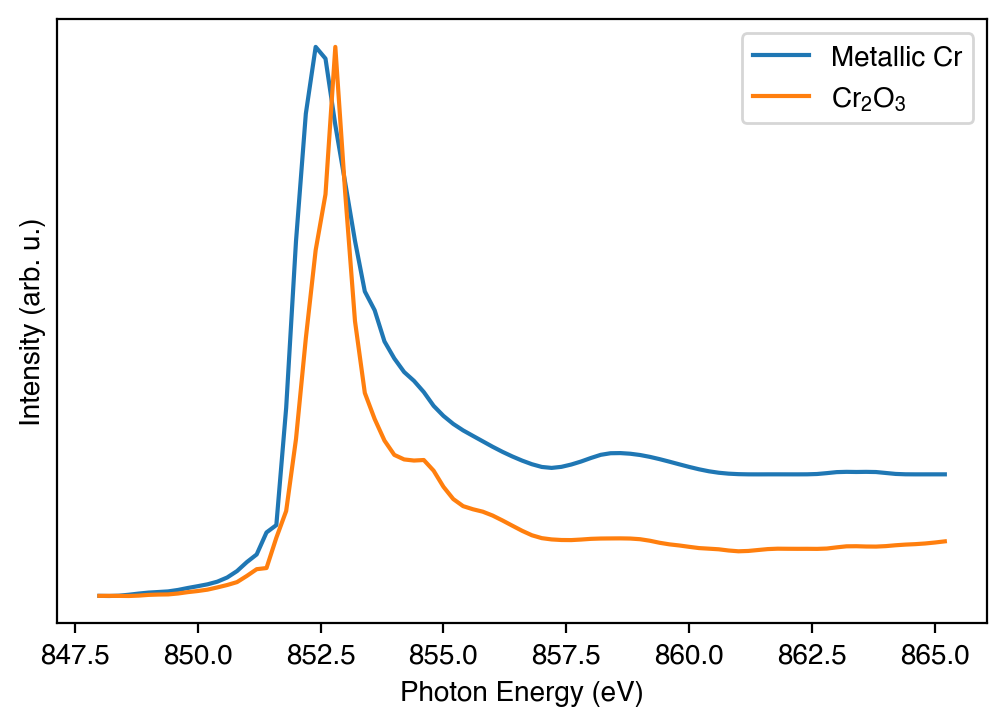

In [5]:
#Visualize the metal and oxide reference spectra
plt.plot(ni_xrange, ni_metal_ref)
plt.plot(ni_xrange, ni_oxide_ref)
plt.legend(("Metallic Cr","$Cr_{2}O_{3}$"))
plt.yticks([])
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")

(101,)


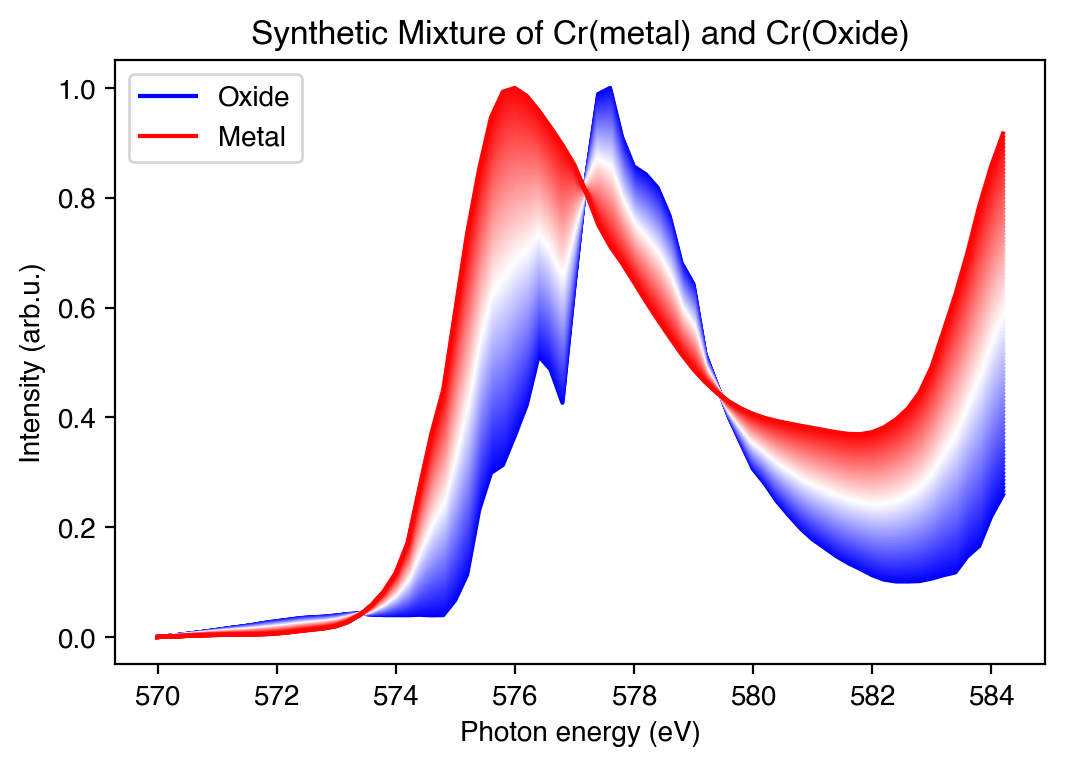

In [6]:
#Make a synthetic series
percentrange = np.arange(0,1.01,.01)
print(percentrange.shape)
synth = np.tile(percentrange,(len(metal_ref),1)).T
synth_metal = np.tile(metal_ref,(len(percentrange),1))*synth
synth_oxide = np.tile(oxide_ref,(len(percentrange),1))*(1-synth)
synth_spectra = synth_metal+synth_oxide

#Optionally add random noise
# noise = np.random.rand(synth_spectra.shape[0],synth_spectra.shape[1])*.05
# synth_spectra = synth_spectra+noise

#plot all the synthetic spectra
rb = cm.get_cmap("bwr")
for i,row in enumerate(synth_spectra):
    if i == 0:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Oxide')
    elif i == len(synth_spectra)-1:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='Metal')
    else:
        plt.plot(xrange, row,c = rb(i/len(percentrange)),label='_nolegend_')
    

plt.ylabel('Intensity (arb.u.)')
plt.xlabel('Photon energy (eV)')
plt.title('Synthetic Mixture of Cr(metal) and Cr(Oxide)')
plt.legend()
#synth_metal = synth_metal*percentrange

0.4475658657278812 0.5524341342721188


Text(0.5, 1.0, 'Cosine Similarity of known synthetic spectra')

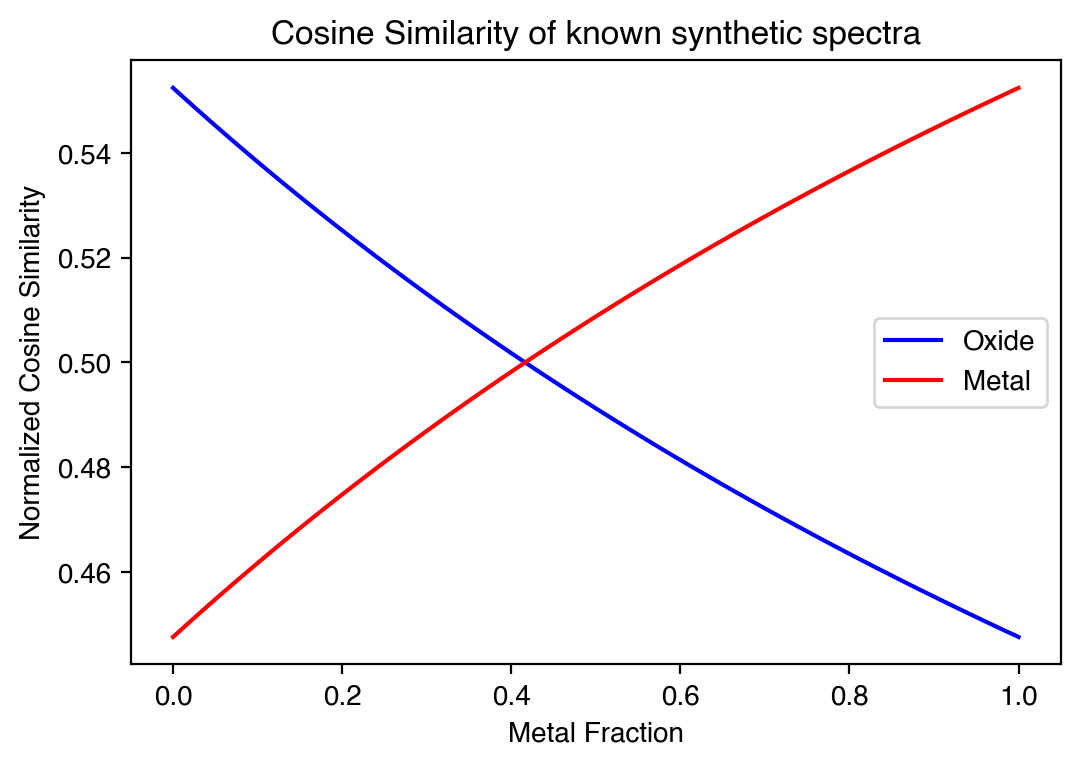

In [7]:
oxide_cs_synth = np.zeros(percentrange.shape)
oxide_cs_list = np.zeros(percentrange.shape)
metal_cs_list = np.zeros(percentrange.shape)
for i, row in enumerate(synth_spectra):
    metal_cs = cosine_similarity_2d(row,metal_ref)
    oxide_cs = cosine_similarity_2d(row,oxide_ref)
    oxide_cs_synth[i] = oxide_cs/(metal_cs+oxide_cs)
    oxide_cs_list[i] = oxide_cs
    metal_cs_list[i] = metal_cs

print(min(oxide_cs_synth),max(oxide_cs_synth))
plt.plot(percentrange,oxide_cs_synth, c='b')
plt.plot(percentrange,1-oxide_cs_synth,c='r')
plt.legend(["Oxide","Metal"])
plt.ylabel("Normalized Cosine Similarity")
plt.xlabel("Metal Fraction")
plt.title("Cosine Similarity of known synthetic spectra")

In [8]:
params = np.polyfit(oxide_cs_synth,1-percentrange,2)
print(params)

oxide_cs_to_percent = np.poly1d(params)

oxide_cs_to_percent(0.505)


[-30.69006309  40.12087749 -11.80374623]


0.6305635629169117

Load the hyperspectral images for all the timesteps

In [9]:
#Ni5Cr Cr L-edge XAS maps
cr5_preox = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230715_Ni5Cr/XAS maps pre-oxidation/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_region2/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_region2.tif")
cr5_ox1 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1_region2/XAS_30um_2CA_1AN_570-584eV_0.2step_Cr2p_ox1_region2.tif")
cr5_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2_region2.tif")
#Ni22Cr6Mo Cr L-edge XAS maps
mo_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation2/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1.tif")
mo_ox1 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_oxidation1.tif")
mo_preox = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p.tif")
#Ni5Cr Ni L-edge XAS
cr5_ni_preox = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230715_Ni5Cr/XAS maps pre-oxidation/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_region2/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_region2.tif")
cr5_ni_ox1 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation1_region2.tif")
cr5_ni_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230716_Ni5Cr/Oxidation XAS mapping/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation2_region2.tif")
#Ni22Cr Ni L-edge XAS
mo_ni_preox = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p.tif")
mo_ni_ox1 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation1/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation1.tif")
mo_ni_ox2 = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation2/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation2.tif")

# #Ni22Cr H2O exposure Cr L-edge XAS
# nicr_h2o_preox = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/Pre-oxidation/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_RT/XAS_30um_2CA_1AN_570-584eV_0.2eV_step_Cr2p_R.tif")
# nicr_h2o_20L = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/20L_H2O/XAS_30um_2CA_2AN_570-584eV_0.2eV_step_Cr2p_200C/XAS_30um_2CA_2AN_570-584eV_0.2eV_step_CR2p_200C.tif")
# #nicr_h20_60L = io.imread("/Users/apple/Sync/Research/NSLS Experiments 7-16-23/20230717_Ni22Cr6Mo/After Second Sputter/XAS Maps/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation2/XAS_30um_2CA_1AN_848-865eV_0.2eV_step_Ni2p_oxidation2.tif")

# #Ni22Cr H2O exposure Ni L-edge XAS
# nicr_h2o_20L_ni2p = io.imread("/Volumes/DATA STICK/6-12-24 Brookhaven XPEEM/20240612_Ni22Cr/20L_H2O/XAS_30um_2CA_2AN_884-865eV_0.2eV_step_Ni2p_200C/XAS_30um_2CA_2AN_884-865eV_0.2_eV_step_Ni2p_200C.tif")


Text(0, 0.5, 'Intensity (arb. u.)')

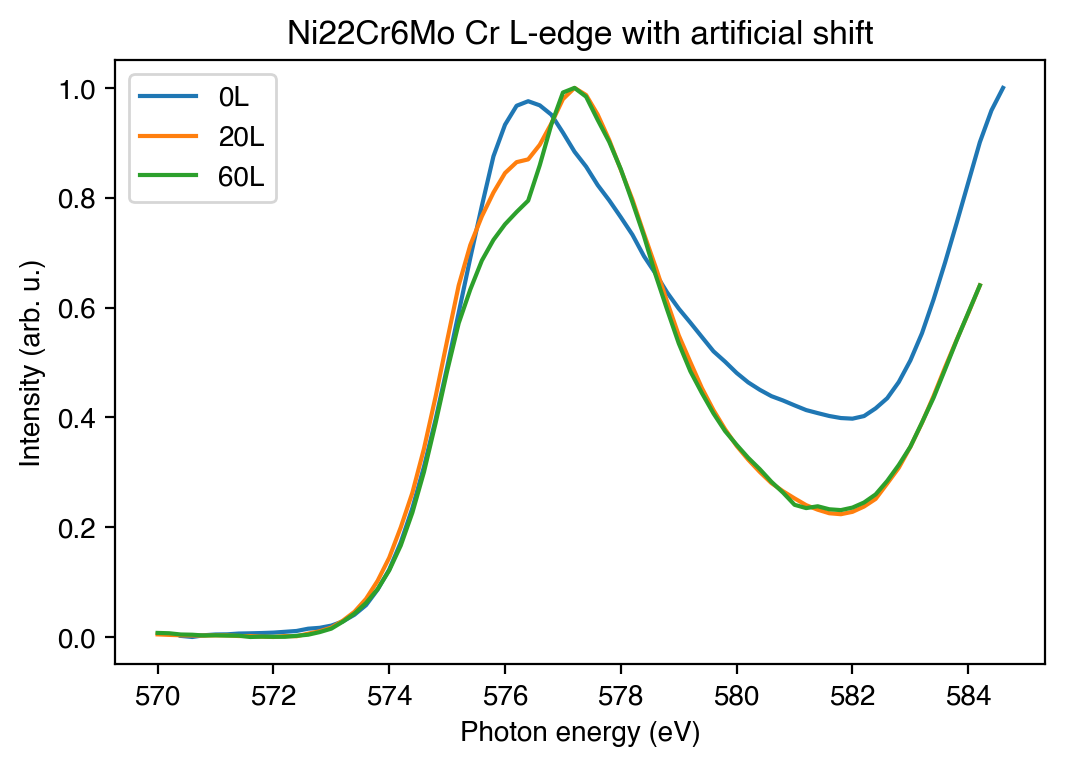

In [10]:
plt.plot(xrange+0.4,(np.average(mo_preox,axis=(1,2))-np.min(np.average(mo_preox,axis=(1,2))))/(np.max(np.average(mo_preox,axis=(1,2)))-np.min(np.average(mo_preox,axis=(1,2)))))
plt.plot(xrange,(np.average(mo_ox1,axis=(1,2))-np.min(np.average(mo_ox1,axis=(1,2))))/(np.max(np.average(mo_ox1,axis=(1,2)))-np.min(np.average(mo_ox1,axis=(1,2)))))
plt.plot(xrange,(np.average(mo_ox2,axis=(1,2))-np.min(np.average(mo_ox2,axis=(1,2))))/(np.max(np.average(mo_ox2,axis=(1,2)))-np.min(np.average(mo_ox2,axis=(1,2)))))

plt.legend(["0L", "20L", "60L"])
plt.title("Ni22Cr6Mo Cr L-edge with artificial shift")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (arb. u.)")

Text(0, 0.5, 'Intensity (arb. u.)')

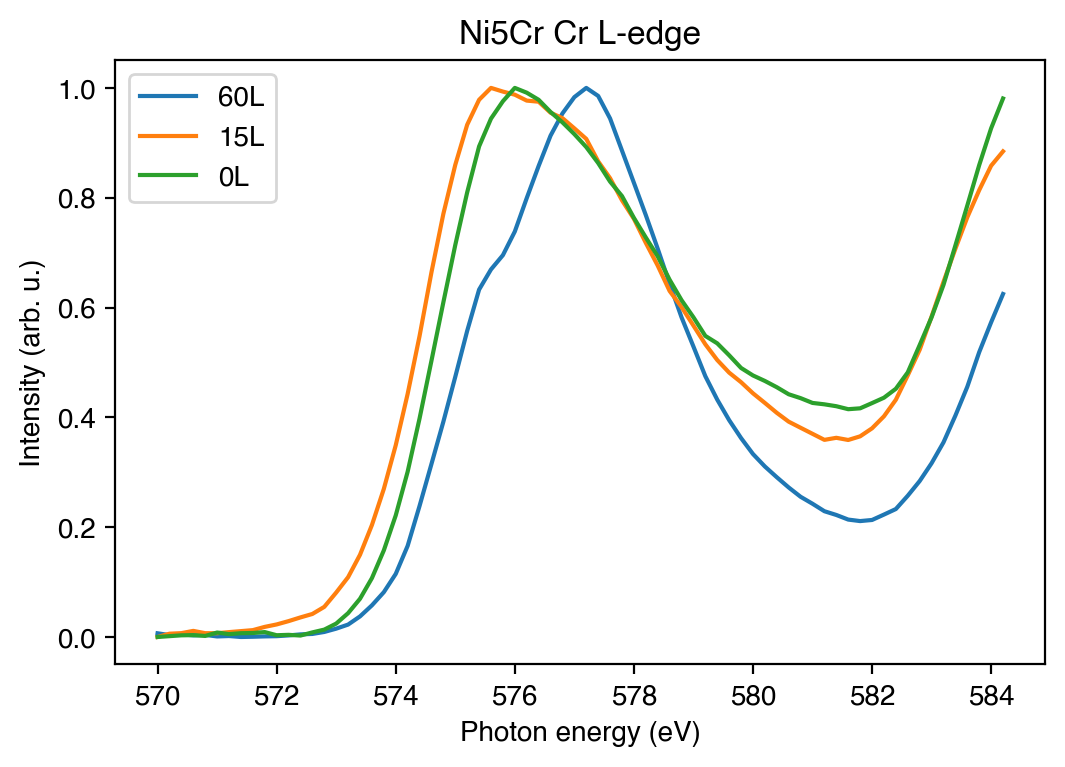

In [11]:
plt.plot(xrange,(np.average(cr5_ox2,axis=(1,2))-np.min(np.average(cr5_ox2,axis=(1,2))))/(np.max(np.average(cr5_ox2,axis=(1,2)))-np.min(np.average(cr5_ox2,axis=(1,2)))))
plt.plot(xrange,(np.average(cr5_ox1,axis=(1,2))-np.min(np.average(cr5_ox1,axis=(1,2))))/(np.max(np.average(cr5_ox1,axis=(1,2)))-np.min(np.average(cr5_ox1,axis=(1,2)))))
plt.plot(xrange,(np.average(cr5_preox,axis=(1,2))-np.min(np.average(cr5_preox,axis=(1,2))))/(np.max(np.average(cr5_preox,axis=(1,2)))-np.min(np.average(cr5_preox,axis=(1,2)))))
plt.legend(["60L", "15L", "0L"])
plt.title("Ni5Cr Cr L-edge")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (arb. u.)")

In [12]:
data = cr5_ox2
print(data.shape)


metal_cs = cosine_similarity_3d(data,metal_ref)
oxide_cs = cosine_similarity_3d(data,oxide_ref)
normed_metal_cs = np.nan_to_num(metal_cs/(metal_cs+oxide_cs))
normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))

print("metal: ", np.average(normed_metal_cs), " oxide: ", np.average(normed_oxide_cs))

(72, 1024, 1024)


<ipython-input-2-06f6105a8416>:7: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))


metal:  0.5304544928975574  oxide:  0.46953978505654415


<ipython-input-12-7f3c710eb2e7>:8: RuntimeWarning: invalid value encountered in true_divide
  normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))


Text(0, 0.5, 'Intensity (arb. u.)')

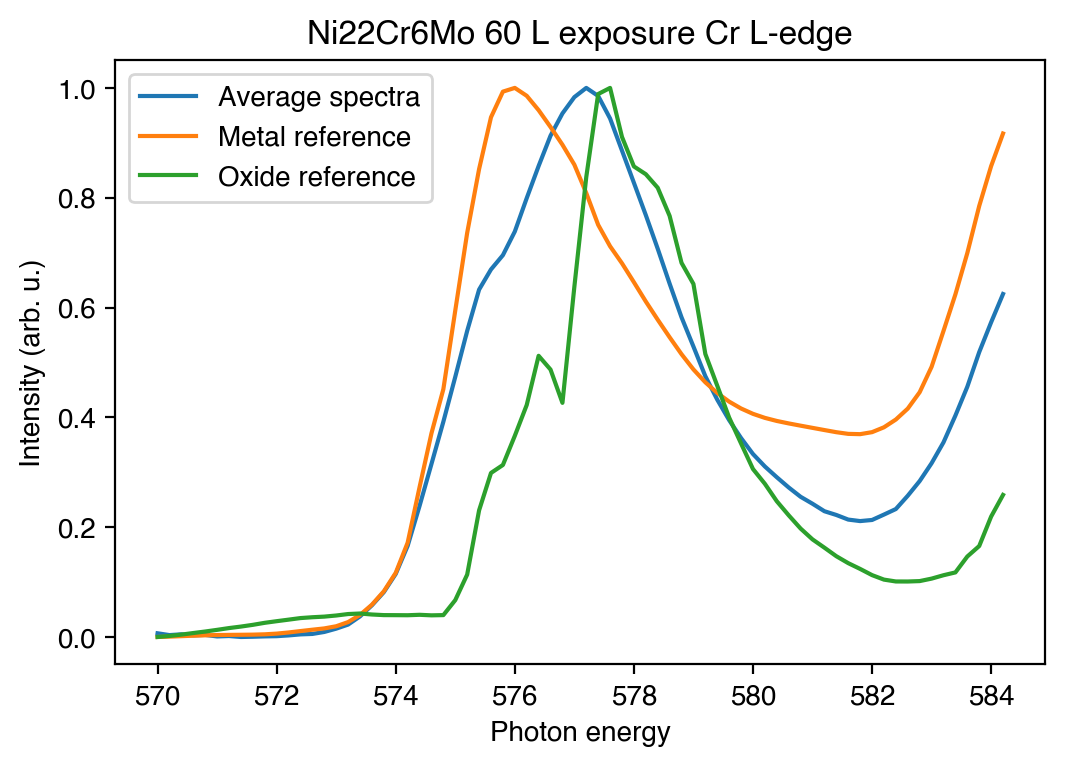

In [13]:
avg_spectra = np.average(data,axis=(1,2))
plt.plot(xrange,(avg_spectra-np.min(avg_spectra))/(np.max(avg_spectra)-np.min(avg_spectra)))
plt.plot(xrange,metal_ref)
plt.plot(xrange,oxide_ref)
plt.title("Ni22Cr6Mo 60 L exposure Cr L-edge")
plt.legend(["Average spectra","Metal reference", "Oxide reference"])
plt.xlabel("Photon energy")
plt.ylabel("Intensity (arb. u.)")

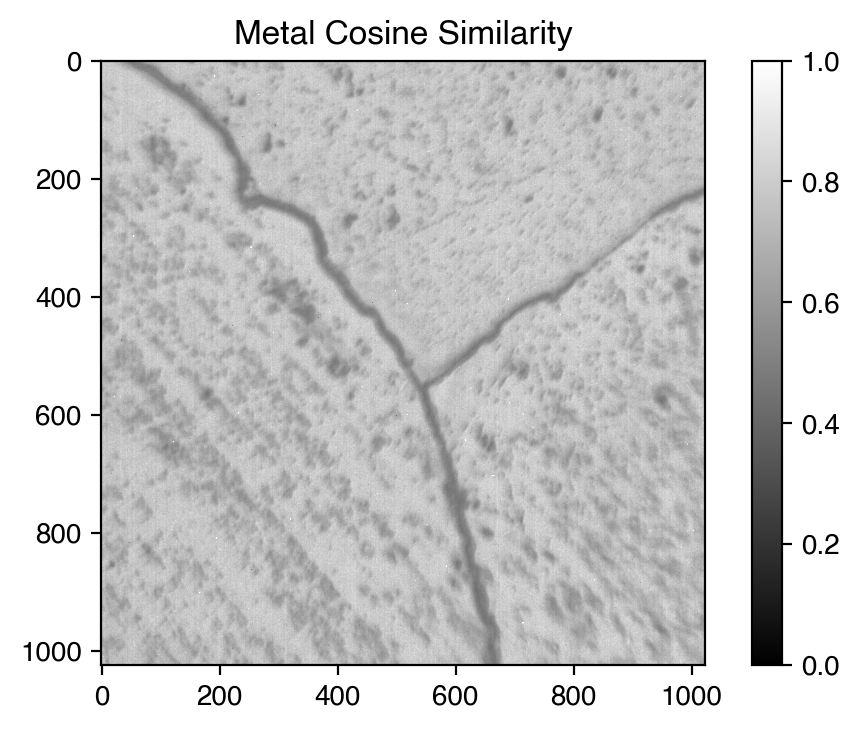

In [14]:
plt.imshow(1-oxide_cs_to_percent(1-normed_metal_cs),cmap='gray',vmin=0,vmax=1)
#plt.imshow(normed_metal_cs,cmap='gray',vmin=np.percentile(normed_metal_cs,1),vmax=np.percentile(normed_metal_cs,99))
plt.title("Metal Cosine Similarity")
plt.colorbar()



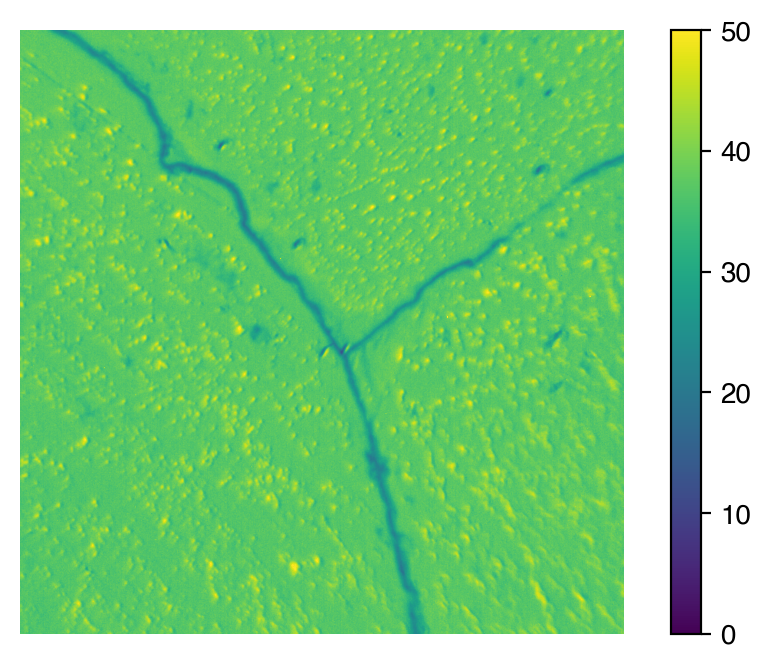

In [27]:
plt.imshow(oxide_cs_to_percent(normed_oxide_cs)*100, cmap='viridis',vmin=0,vmax=50)
#plt.imshow(normed_oxide_cs,cmap='gray',vmin=np.percentile(normed_oxide_cs,1),vmax=np.percentile(normed_oxide_cs,99))
#plt.title("Cr L-edge Cr2O3 Linear combination concentration")
plt.axis('off')
plt.colorbar()

In [16]:
# oxide_cosine_img = 32767*np.nan_to_num(normed_oxide_cs)
# imsave("oxide_cosine_score.tif", oxide_cosine_img.astype(np.int16))

In [17]:
# plt.violinplot(np.ndarray.flatten(oxide_cs))
# plt.violinplot(np.ndarray.flatten(metal_cs))
# #plt.legend(["Oxide", "Metal"])

Measure the similarity for Ni spectra in the Ni5Cr samples

In [18]:
data = cr5_ni_ox2
print(data.shape)


metal_cs = cosine_similarity_3d(data,ni_metal_ref)
oxide_cs = cosine_similarity_3d(data,ni_oxide_ref)
normed_metal_cs = np.nan_to_num(metal_cs/(metal_cs+oxide_cs))
normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))

print("metal: ", np.average(normed_metal_cs), " oxide: ", np.average(normed_oxide_cs))

(87, 1024, 1024)
metal:  0.521036502046039  oxide:  0.478963497953961


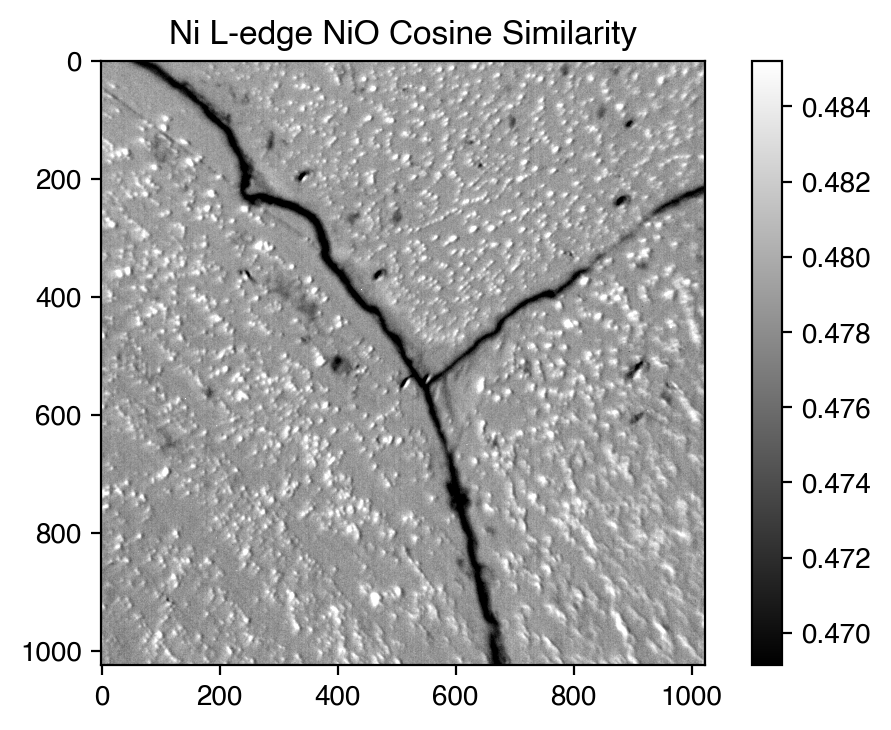

In [19]:
plt.imshow(normed_oxide_cs,cmap='gray',vmin=np.percentile(normed_oxide_cs,1),vmax=np.percentile(normed_oxide_cs,99))
plt.title("Ni L-edge NiO Cosine Similarity")
plt.colorbar()
oxide_cosine_img = 32767*np.nan_to_num(normed_oxide_cs)
imsave("Ni_oxide_cosine_score.tif", oxide_cosine_img.astype(np.int16))

Visualize the average spectra and spectra over time for the Ni5Cr and the Ni22Cr6Mo

Text(0, 0.5, 'Intensity (arb. u.)')

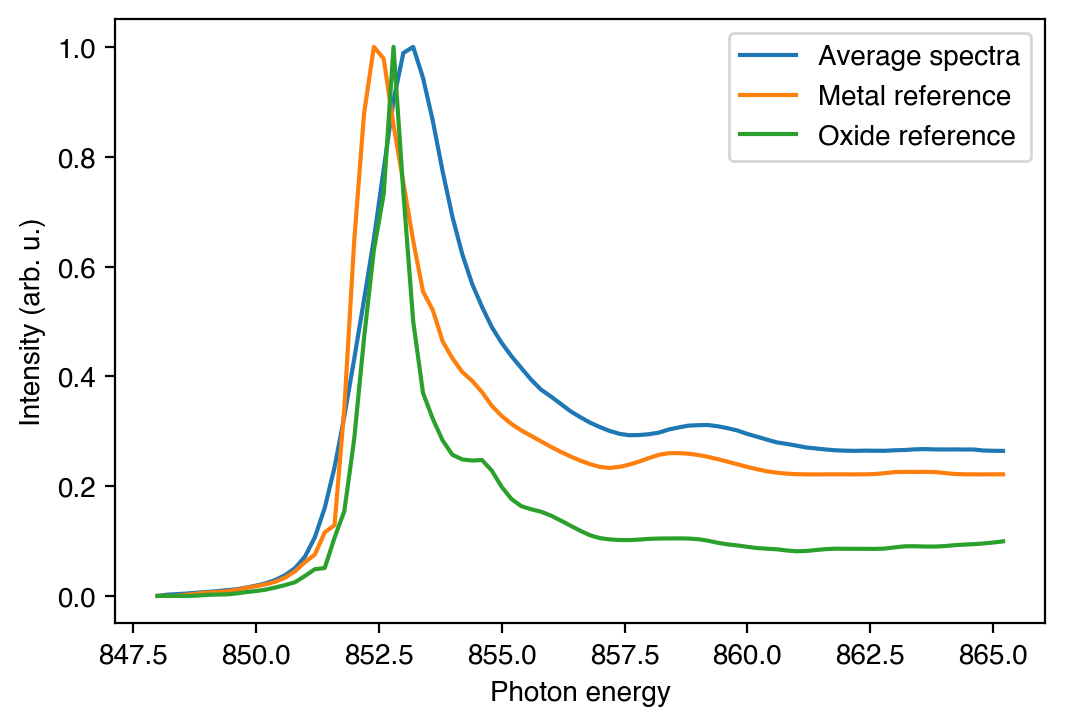

In [20]:
avg_spectra = np.average(cr5_ni_ox2,axis=(1,2))
plt.plot(ni_xrange,(avg_spectra-np.min(avg_spectra))/(np.max(avg_spectra)-np.min(avg_spectra)))
plt.plot(ni_xrange,ni_metal_ref)
plt.plot(ni_xrange,ni_oxide_ref)
#plt.title("Ni22Cr6Mo 60 L exposure Cr L-edge")
plt.legend(["Average spectra","Metal reference", "Oxide reference"])
plt.xlabel("Photon energy")
plt.ylabel("Intensity (arb. u.)")

Text(0, 0.5, 'Intensity (arb. u.)')

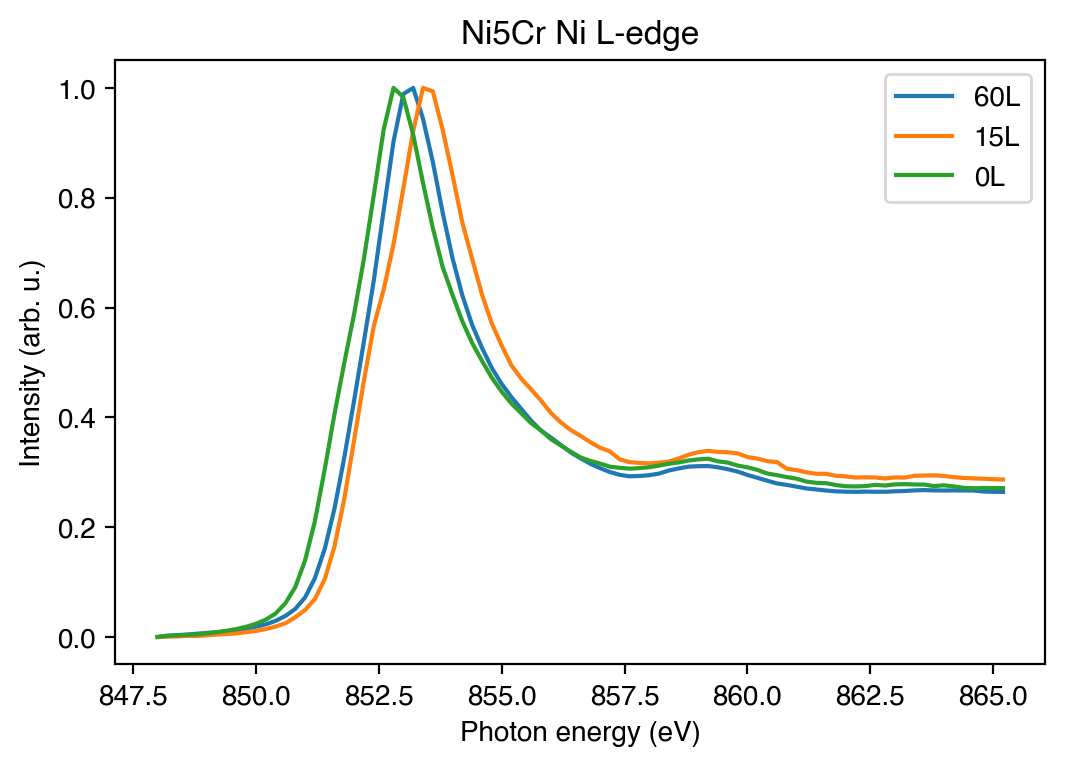

In [21]:
plt.plot(ni_xrange,(np.average(cr5_ni_ox2,axis=(1,2))-np.min(np.average(cr5_ni_ox2,axis=(1,2))))/(np.max(np.average(cr5_ni_ox2,axis=(1,2)))-np.min(np.average(cr5_ni_ox2,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(cr5_ni_ox1,axis=(1,2))-np.min(np.average(cr5_ni_ox1,axis=(1,2))))/(np.max(np.average(cr5_ni_ox1,axis=(1,2)))-np.min(np.average(cr5_ni_ox1,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(cr5_ni_preox,axis=(1,2))-np.min(np.average(cr5_ni_preox,axis=(1,2))))/(np.max(np.average(cr5_ni_preox,axis=(1,2)))-np.min(np.average(cr5_ni_preox,axis=(1,2)))))
plt.legend(["60L", "15L", "0L"])
plt.title("Ni5Cr Ni L-edge")
plt.xlabel("Photon energy (eV)")
plt.ylabel("Intensity (arb. u.)")


Text(0.5, 0, 'Photon energy (eV)')

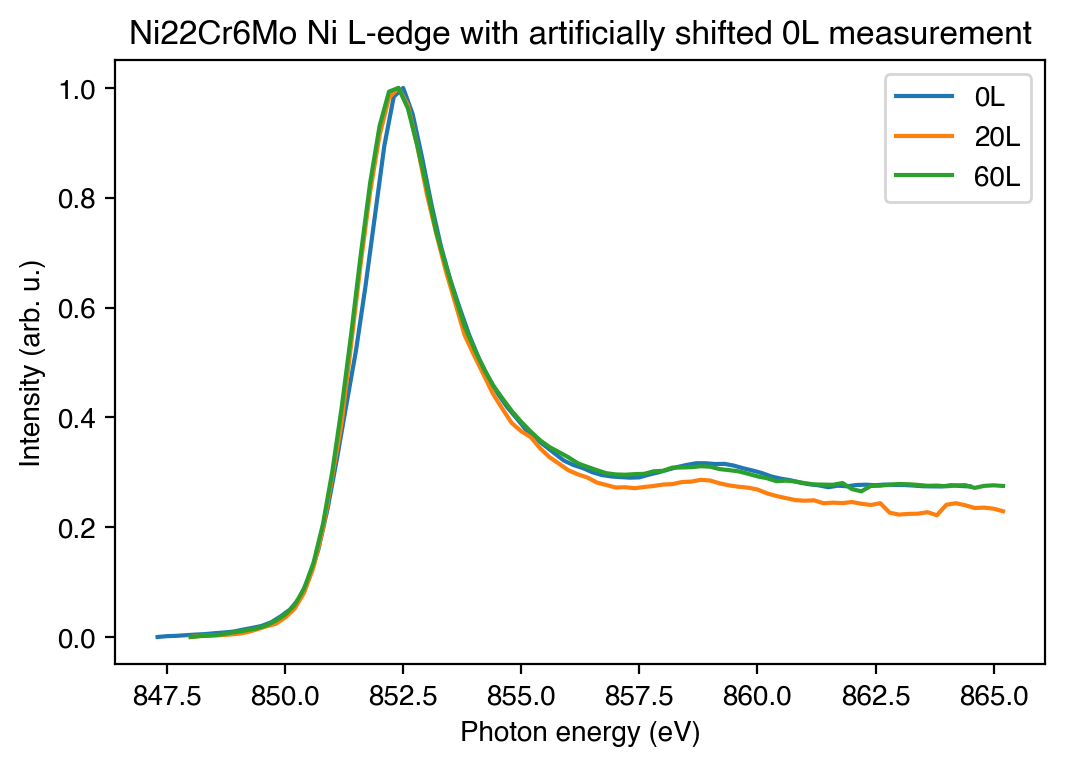

In [22]:
plt.plot(ni_xrange-.7,(np.average(mo_ni_preox,axis=(1,2))-np.min(np.average(mo_ni_preox,axis=(1,2))))/(np.max(np.average(mo_ni_preox,axis=(1,2)))-np.min(np.average(mo_ni_preox,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(mo_ni_ox1,axis=(1,2))-np.min(np.average(mo_ni_ox1,axis=(1,2))))/(np.max(np.average(mo_ni_ox1,axis=(1,2)))-np.min(np.average(mo_ni_ox1,axis=(1,2)))))
plt.plot(ni_xrange,(np.average(mo_ni_ox2,axis=(1,2))-np.min(np.average(mo_ni_ox2,axis=(1,2))))/(np.max(np.average(mo_ni_ox2,axis=(1,2)))-np.min(np.average(mo_ni_ox2,axis=(1,2)))))
plt.legend(["0L","20L","60L"])
plt.title("Ni22Cr6Mo Ni L-edge with artificially shifted 0L measurement")
plt.ylabel("Intensity (arb. u.)")
plt.xlabel("Photon energy (eV)")

Overlay of the Ni oxides and the Cr oxides 

In [23]:
#generate the cosine similarity for the Ni5Cr Cr L-edge similarity to Cr2O3
metal_cs = cosine_similarity_3d(cr5_ox2,metal_ref)
oxide_cs = cosine_similarity_3d(cr5_ox2,oxide_ref)
normed_metal_cs = np.nan_to_num(metal_cs/(metal_cs+oxide_cs))
normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))
print(np.percentile(normed_oxide_cs,1),np.percentile(normed_oxide_cs,99))
cr5_60L_cr203 = normed_oxide_cs

#generate the cosine similarity for the Ni5Cr Ni L-edge similarity to NiO
metal_cs = cosine_similarity_3d(cr5_ni_ox2,ni_metal_ref)
oxide_cs = cosine_similarity_3d(cr5_ni_ox2,ni_oxide_ref)
normed_metal_cs = np.nan_to_num(metal_cs/(metal_cs+oxide_cs))
normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))
print(np.percentile(normed_oxide_cs,1),np.percentile(normed_oxide_cs,99))
cr5_60L_NiO = normed_oxide_cs



<ipython-input-2-06f6105a8416>:7: RuntimeWarning: invalid value encountered in true_divide
  cosine = np.dot(flat_image,reference)/(norm*np.linalg.norm(reference))
<ipython-input-23-4ed50b659bee>:4: RuntimeWarning: invalid value encountered in true_divide
  normed_metal_cs = np.nan_to_num(metal_cs/(metal_cs+oxide_cs))
<ipython-input-23-4ed50b659bee>:5: RuntimeWarning: invalid value encountered in true_divide
  normed_oxide_cs = np.nan_to_num(oxide_cs/(metal_cs+oxide_cs))


0.45806875262458774 0.4909436589251478
0.46915257977602304 0.48522164144452584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1024, 1024, 3)


Text(0.5, 1.0, 'Composite of NiO CS (blue) and Cr2O3 CS (red)')

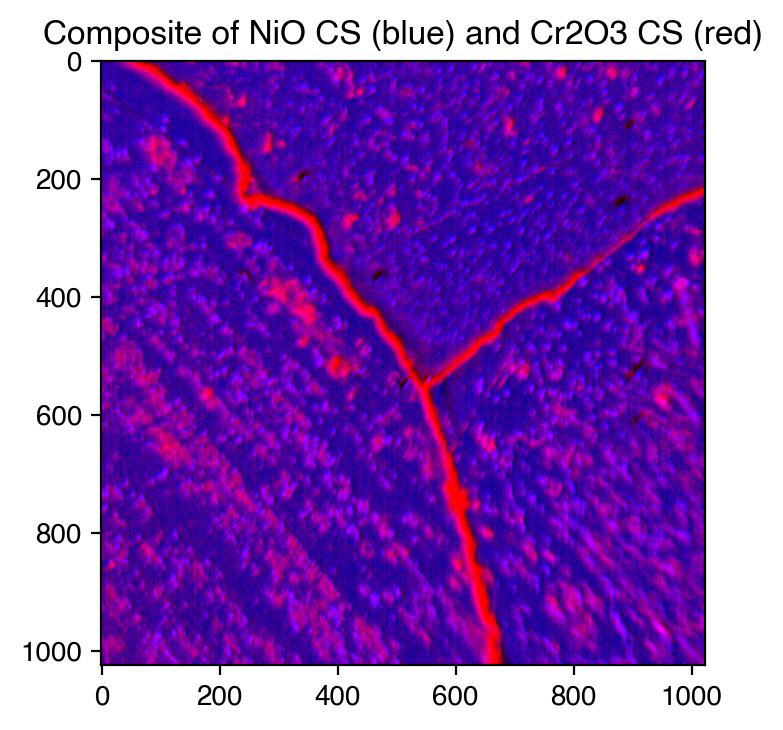

In [24]:
blank = np.zeros(cr5_60L_NiO.shape)
multichannel_cr5_60L = np.dstack([(cr5_60L_cr203-.458)/(.491-.458),blank,(cr5_60L_NiO-.469)/(.485-.469)])
print(multichannel_cr5_60L.shape)
plt.imshow(multichannel_cr5_60L)
plt.title("Composite of NiO CS (blue) and Cr2O3 CS (red)")